## Experiment Setup

###  Random seed / PyTorch / Colab / CUDA related

In [1]:
import torch
import numpy as np

# Google Colab-only setup.
use_colab = True

# Is this running on Colab?
import importlib
colab_available = importlib.util.find_spec("google.colab") is not None

if use_colab and colab_available:
    # Mount my Google Drive root folder
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Pyro
    !pip install pyro-ppl

    # cd to bayesian-dl-experiments directory
    %cd 'drive/My Drive/Colab Notebooks/bayesian-dl-experiments'
    !ls

# IPython reloading magic
%load_ext autoreload
%autoreload 2

# Random seeds
# Based on https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(682)
np.random.seed(682)

# torch.device / CUDA Setup
use_cuda = True

if use_cuda and torch.cuda.is_available():
    torch_device = torch.device('cuda')
    torch.backends.cudnn.deterministic = True
    # Note: https://discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
    torch.backends.cudnn.benchmark = False
    use_pin_memory=True # Faster Host to GPU copies with page-locked memory
else:
    torch_device = torch.device('cpu')
    use_pin_memory=False

### Variable settings

In [2]:
"""
Toy dataset generation based on the experiment from 
the Probabilstic Backpropagation paper (Hernandez-Lobato & Adams, 2015)
"""
# Random seed for toy dataset
dataset_toy_random_seed = 691

# Toy dataset size
dataset_toy_size = 20

# Toy dataset x distribution (uniform) parameters
dataset_toy_x_low = -4
dataset_toy_x_high = 4

# Toy dataset y distribution (normal with noise)
dataset_toy_y_mean = 0
dataset_toy_y_std = 9

# L2 regularization strength
reg_strength = 0.01

# Epochs
n_epochs = 4000

# Number of test predictions (for each data point)
n_predictions = 10000

## Prepare data

### Get the data as a torch Dataset object

In [3]:
from torch.utils.data import random_split, DataLoader
from ronald_bdl import datasets

dataset = datasets.ToyDatasets(
    random_seed=dataset_toy_random_seed,
    n_samples=dataset_toy_size,
    x_low=dataset_toy_x_low,
    x_high=dataset_toy_x_high,
    y_mean=dataset_toy_y_mean,
    y_std=dataset_toy_y_std,
)

# Get the test data
X_test = torch.linspace(dataset_toy_x_low, dataset_toy_x_high, 100).reshape(100, 1)

# Print the size of the dataset
print("dataset size = " + str((len(dataset), dataset.n_features)))

dataset size = (20, 1)


## Define network

In [4]:
from ronald_bdl import models

uncertainty_methods = []

# MC (Bernoulli) dropout
uncertainty_methods.append(
    models.FCNetMCDropout(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        dropout_rate=0.5,
        dropout_type='bernoulli',
    )
)

# Variational Dropout
uncertainty_methods.append(
    models.FCNetMCDropout(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
        dropout_rate=0.5,
        dropout_type='variational',
        dropout_variational_dim=100,
    )
)

# Vanilla Variational Inference
uncertainty_methods.append(
    models.FCNetVariationalInference(
        input_dim=dataset.n_features, 
        output_dim=dataset.n_targets,
        hidden_dim=100,
        n_hidden=0,
    )
)

## Train the network

### Train/test the model

In [5]:
import time
import pyro
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive

for network in uncertainty_methods:
    
    # Send the whole model to the selected torch.device
    network.to(torch_device)

    # Print the network structure
    print(network)

    train_loader = DataLoader(dataset, pin_memory=use_pin_memory)
    
    if isinstance(network, models.FCNetMCDropout):
        # Adam optimizer
        # https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam
        # NOTE: Need to set L2 regularization from here
        optimizer = torch.optim.Adam(
            network.parameters(),
            lr=0.01,
            weight_decay=reg_strength, # L2 regularization
        )

        # Mean Squared Error for loss function to minimize
        objective = torch.nn.MSELoss()

    elif isinstance(network, models.FCNetVariationalInference):
        optimizer = pyro.optim.Adam({"lr": 0.03})
        svi = SVI(network.model, network.guide, optimizer, loss=Trace_ELBO(), num_samples=5000)
        pyro.clear_param_store()
    
    """
    Training
    """
    # Model to train mode
    network.train()

    # Record training start time (for this method)
    tic = time.time()

    for epoch in range(n_epochs): # loop over the dataset multiple times

        for i, data in enumerate(train_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, targets = data

            # Store the batch to torch_device's memory
            inputs = inputs.to(torch_device)
            targets = targets.to(torch_device)

            if isinstance(network, models.FCNetMCDropout):
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = network(inputs)

                loss = objective(outputs, targets)
                loss.backward()

                optimizer.step()
            elif isinstance(network, models.FCNetVariationalInference):
                # calculate the loss and take a gradient step
                loss = svi.step(inputs, targets)

        if epoch % 100 == 0:
            print("[iteration %04d] loss: %.4f" % (epoch + 1, loss))
            
    # Record training end time
    toc = time.time()

    # Report the final loss
    print("final loss = " + str(loss))            

    # Report the total training time
    print("training time = " + str(toc - tic) + " seconds")
    
    print()
    

FCNetMCDropout(
  (input): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): Dropout(p=0.5, inplace=False)
  )
  (output): Linear(in_features=100, out_features=1, bias=True)
)
[iteration 0001] loss: 111.6195
[iteration 0101] loss: 140.6345
[iteration 0201] loss: 110.9231
[iteration 0301] loss: 153.7391
[iteration 0401] loss: 126.8225
[iteration 0501] loss: 163.5590
[iteration 0601] loss: 175.9022
[iteration 0701] loss: 171.0264
[iteration 0801] loss: 151.6326
[iteration 0901] loss: 162.9378
[iteration 1001] loss: 158.5289
[iteration 1101] loss: 240.6162
[iteration 1201] loss: 136.9831
[iteration 1301] loss: 169.9579
[iteration 1401] loss: 126.5825
[iteration 1501] loss: 178.2463
[iteration 1601] loss: 189.7122
[iteration 1701] loss: 185.5334
[iteration 1801] loss: 195.2567
[iteration 1901] loss: 151.6911
[iteration 2001] loss: 174.2972
[iteration 2101] loss: 214.4264
[iteration 2201] loss: 169.4642
[iteration 2301] loss: 212.1131
[iteration 2401] loss: 16

/Users/se9/python/00_default/lib/python3.6/site-packages/pyro/infer/trace_elbo.py:135: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


[iteration 0101] loss: nan
[iteration 0201] loss: nan
[iteration 0301] loss: nan
[iteration 0401] loss: nan
[iteration 0501] loss: nan
[iteration 0601] loss: nan
[iteration 0701] loss: nan
[iteration 0801] loss: nan
[iteration 0901] loss: nan
[iteration 1001] loss: nan
[iteration 1101] loss: nan
[iteration 1201] loss: nan
[iteration 1301] loss: nan
[iteration 1401] loss: nan
[iteration 1501] loss: nan
[iteration 1601] loss: nan
[iteration 1701] loss: nan
[iteration 1801] loss: nan
[iteration 1901] loss: nan
[iteration 2001] loss: nan
[iteration 2101] loss: nan
[iteration 2201] loss: nan
[iteration 2301] loss: nan
[iteration 2401] loss: nan
[iteration 2501] loss: nan
[iteration 2601] loss: nan
[iteration 2701] loss: nan
[iteration 2801] loss: nan
[iteration 2901] loss: nan
[iteration 3001] loss: nan
[iteration 3101] loss: nan
[iteration 3201] loss: nan
[iteration 3301] loss: nan
[iteration 3401] loss: nan
[iteration 3501] loss: nan
[iteration 3601] loss: nan
[iteration 3701] loss: nan
[

testing time = 3.132450819015503 seconds

Mean = tensor([[-52.0701],
        [-50.2382],
        [-48.2919],
        [-46.3128],
        [-44.4719],
        [-42.6220],
        [-40.6570],
        [-38.6267],
        [-36.8871],
        [-34.9638],
        [-33.0836],
        [-31.0770],
        [-29.2389],
        [-27.3162],
        [-25.3780],
        [-23.7452],
        [-21.8100],
        [-20.0336],
        [-18.2873],
        [-16.5805],
        [-14.9293],
        [-13.2954],
        [-11.6679],
        [-10.1488],
        [ -8.9310],
        [ -7.7515],
        [ -6.8443],
        [ -6.0919],
        [ -5.5148],
        [ -5.0174],
        [ -4.6261],
        [ -4.2497],
        [ -3.8921],
        [ -3.5061],
        [ -3.1647],
        [ -2.7796],
        [ -2.4099],
        [ -2.0400],
        [ -1.6395],
        [ -1.2831],
        [ -0.9031],
        [ -0.5848],
        [ -0.1721],
        [  0.1991],
        [  0.5969],
        [  0.9732],
        [  1.3581],
        [  

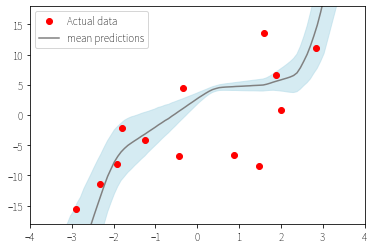

testing time = 4.656950950622559 seconds

Mean = tensor([[-26.4846],
        [-26.7092],
        [-26.4183],
        [-26.2886],
        [-26.2085],
        [-25.9852],
        [-25.7188],
        [-25.2614],
        [-24.8084],
        [-24.4994],
        [-23.8009],
        [-23.2016],
        [-22.7003],
        [-22.1359],
        [-21.4802],
        [-20.8290],
        [-20.2370],
        [-19.7591],
        [-19.0597],
        [-18.3890],
        [-17.7708],
        [-17.2667],
        [-16.5662],
        [-15.9450],
        [-15.2671],
        [-14.5777],
        [-14.0859],
        [-13.5045],
        [-12.7648],
        [-12.2270],
        [-11.5982],
        [-10.9240],
        [-10.3420],
        [ -9.7003],
        [ -8.9926],
        [ -8.4665],
        [ -7.9701],
        [ -7.2930],
        [ -6.5824],
        [ -6.0229],
        [ -5.3533],
        [ -4.8119],
        [ -4.0877],
        [ -3.5277],
        [ -2.8764],
        [ -2.2899],
        [ -1.5880],
        [ -

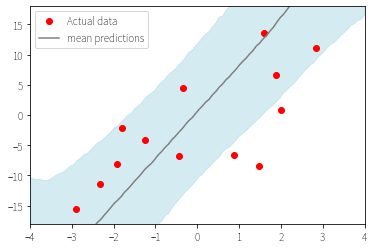

testing time = 15.626370906829834 seconds

Mean = tensor([[-5.3268e+01],
        [-5.1971e+01],
        [-5.0674e+01],
        [-4.9377e+01],
        [-4.8084e+01],
        [-4.6794e+01],
        [-4.5504e+01],
        [-4.4213e+01],
        [-4.2923e+01],
        [-4.1633e+01],
        [-4.0342e+01],
        [-3.9052e+01],
        [-3.7762e+01],
        [-3.6472e+01],
        [-3.5181e+01],
        [-3.3891e+01],
        [-3.2601e+01],
        [-3.1311e+01],
        [-3.0020e+01],
        [-2.8730e+01],
        [-2.7440e+01],
        [-2.6149e+01],
        [-2.4859e+01],
        [-2.3569e+01],
        [-2.2279e+01],
        [-2.0988e+01],
        [-1.9698e+01],
        [-1.8408e+01],
        [-1.7117e+01],
        [-1.5827e+01],
        [-1.4537e+01],
        [-1.3247e+01],
        [-1.1956e+01],
        [-1.0666e+01],
        [-9.3758e+00],
        [-8.0855e+00],
        [-6.7952e+00],
        [-5.5050e+00],
        [-4.2147e+00],
        [-2.9244e+00],
        [-1.6341e+00],
       

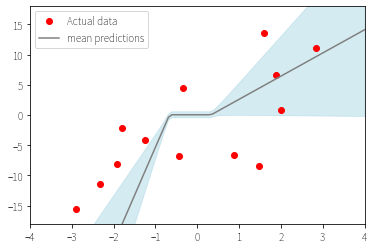

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

for network in uncertainty_methods:

    """
    Testing
    """
    # Model to eval mode
    network.eval()

    # Record testing start time (for this split)
    tic_testing = time.time()    
    
    predictions, mean, var, metrics = network.predict_dist(X_test, n_predictions)

    # Record testing end time
    toc_testing = time.time()
    
    # Report the total testing time
    print("testing time = " + str(toc_testing - tic_testing) + " seconds")
    
    """
    Print results
    """
    print()
    print("Mean = " + str(mean))
    print("Variance = " + str(var))
                
    # Plot the uncertainty measured by each methods
    plt.figure()
    
    # Fix the scales of x-axis and y-axis
    plt.xlim(dataset_toy_x_low, dataset_toy_x_high)
    plt.ylim(dataset_toy_y_mean-2*dataset_toy_y_std, dataset_toy_y_mean+2*dataset_toy_y_std)

    # Actual data
    plt.plot(dataset.data_x, dataset.data_y, 'or', label='Actual data')

    # MC prediction
    plt.plot(X_test, mean, 'gray', label='mean predictions')

    # Distributions around the predictions
    plt.fill_between(X_test.flatten(), (mean - 2*torch.sqrt(var)).flatten(), (mean + 2*torch.sqrt(var)).flatten(),
                     color='lightblue', alpha=0.5)
    
    plt.legend()
    
    plt.show()